# 2D Plane Strain FEA -- Fillets, Junction Widening & Constraint

Extension of notebook **4a** with three geometry/BC improvements to address
unrealistic buckling at beam-shuttle junctions:

1. **Fillet** -- `buffer(-r).buffer(+r)` rounds concave interior corners
2. **Junction widening** -- triangular gussets at beam-shuttle attachments
3. **Junction BC** -- u_x=0 at beam-shuttle interface nodes

Runs at **10% mesh density only** for quick iteration.
Includes a **flex-ratio sweep** and **parameter sweeps** (rigid width, apex height, span).

All sweeps use displacement range -0.2 to 2.2 um.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import triangle as tr
import skfem
from skfem import *
from skfem.models.elasticity import linear_elasticity, lame_parameters
from skfem.helpers import dot, ddot, sym_grad, transpose, eye, grad, det, inv
from skfem.assembly import BilinearForm, LinearForm

sys.path.insert(0, os.path.dirname(os.path.abspath('__file__')))
from full_spring_utils import (
    POLY_SI, DEFAULT_FULL_SPRING_PARAMS,
    get_full_spring_polygon, identify_bc_nodes_2d,
    find_physical_xlim,
)

print(f'scikit-fem version: {skfem.__version__}')

# Parameters
P = DEFAULT_FULL_SPRING_PARAMS
anchor_dist = P['anchor_distance']
half_span = P['half_span']
shuttle_len = P['shuttle_length']
h = P['initial_offset']
t = POLY_SI['t']
E = POLY_SI['E']
nu = POLY_SI['nu']
lam, mu = lame_parameters(E, nu)

# Fillet & widening parameters
FILLET_RADIUS = 0.3       # um
JUNCTION_WIDENING = 0.7   # um extra half-width at shuttle face

print(f'Full spring: anchor_dist={anchor_dist} um, half_span={half_span} um')
print(f'  h={h} um, t={t} um, Q={h/t:.2f}')
print(f'  fillet_radius={FILLET_RADIUS} um, junction_widening={JUNCTION_WIDENING} um')
print(f'Lame: lam={lam:.1f}, mu={mu:.1f} MPa')

os.makedirs('plots', exist_ok=True)
os.makedirs('results', exist_ok=True)

scikit-fem version: 12.0.1
Full spring: anchor_dist=80.0 um, half_span=36.5 um
  h=1.2 um, t=0.5 um, Q=2.40
  fillet_radius=0.3 um, junction_widening=0.7 um
Lame: lam=51522.2, mu=65573.8 MPa


## 1. Geometry: Original vs Filleted

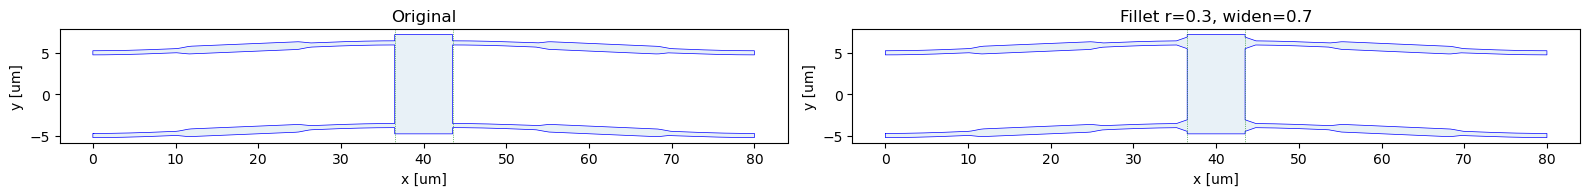

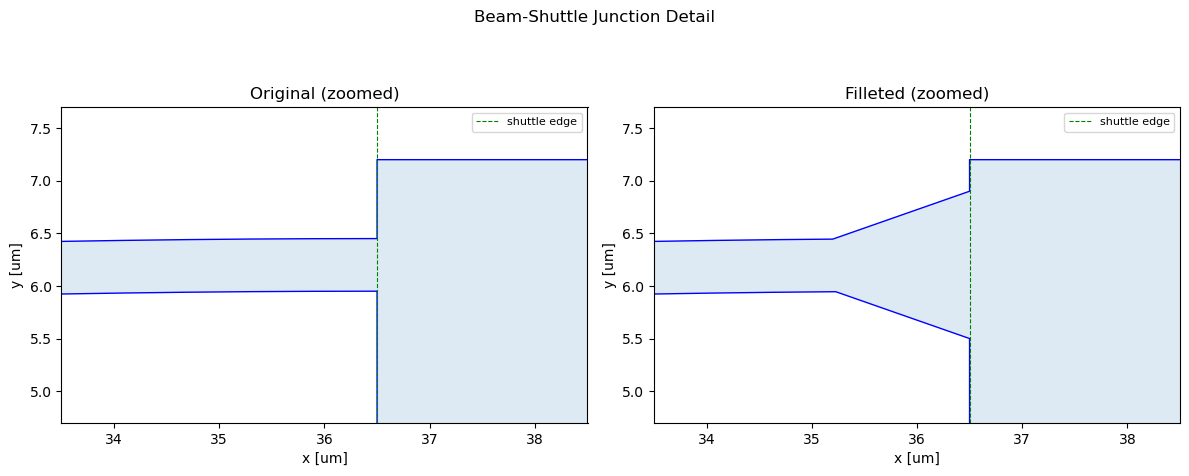

Original: 4805 vertices, Filleted: 3840 vertices


In [2]:
# Generate both polygons
poly_orig = get_full_spring_polygon(n_points=600)
poly_fillet = get_full_spring_polygon(
    n_points=600,
    fillet_radius=FILLET_RADIUS,
    junction_widening=JUNCTION_WIDENING,
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Full view comparison
for ax, poly, title in [
    (axes[0], poly_orig, 'Original'),
    (axes[1], poly_fillet, f'Fillet r={FILLET_RADIUS}, widen={JUNCTION_WIDENING}'),
]:
    ax.plot(poly[:, 0], poly[:, 1], 'b-', linewidth=0.5)
    ax.fill(poly[:, 0], poly[:, 1], alpha=0.1)
    ax.set_aspect('equal')
    ax.set_xlabel('x [um]')
    ax.set_ylabel('y [um]')
    ax.set_title(title)
    ax.axvline(half_span, color='g', ls=':', lw=0.5)
    ax.axvline(half_span + shuttle_len, color='g', ls=':', lw=0.5)

fig.tight_layout()
plt.show()

# Zoomed inset at upper-left beam-shuttle junction
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
beam_y = h + P['beam_spacing'] / 2.0
zoom_x = (half_span - 3, half_span + 2)
zoom_y = (beam_y - 1.5, beam_y + 1.5)

for ax, poly, title in [
    (axes[0], poly_orig, 'Original (zoomed)'),
    (axes[1], poly_fillet, 'Filleted (zoomed)'),
]:
    ax.plot(poly[:, 0], poly[:, 1], 'b-', linewidth=1.0)
    ax.fill(poly[:, 0], poly[:, 1], alpha=0.15)
    ax.set_xlim(zoom_x)
    ax.set_ylim(zoom_y)
    ax.set_aspect('equal')
    ax.set_xlabel('x [um]')
    ax.set_ylabel('y [um]')
    ax.set_title(title)
    ax.axvline(half_span, color='g', ls='--', lw=0.8, label='shuttle edge')
    ax.legend(fontsize=8)

fig.suptitle('Beam-Shuttle Junction Detail', fontsize=12)
fig.tight_layout()
fig.savefig('plots/skfem_2d_fillet_geometry_zoom.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Original: {len(poly_orig)} vertices, Filleted: {len(poly_fillet)} vertices')

## 2. Nonlinear Forms (Total Lagrangian)

Same formulation as notebook 4a.

In [3]:
I2 = np.eye(2).reshape(2, 2, 1, 1)

def mat(A, B):
    """Matrix-matrix product for (2,2,...) tensor fields."""
    return np.einsum('ij...,jk...->ik...', A, B)

@BilinearForm
def stiffness_nl(u, v, w):
    """Tangent stiffness for Total Lagrangian with St. Venant-Kirchhoff material."""
    du = grad(w['prev'])
    F = I2 + du
    GL = 0.5 * (mat(transpose(F), F) - I2)
    trE = GL[0, 0] + GL[1, 1]
    S = lam * trE * I2 + 2.0 * mu * GL

    dv = grad(v)
    dw = grad(u)

    dGL = 0.5 * (mat(transpose(F), dw) + mat(transpose(dw), F))
    trDE = dGL[0, 0] + dGL[1, 1]
    dS = lam * trDE * I2 + 2.0 * mu * dGL
    dGL_v = 0.5 * (mat(transpose(F), dv) + mat(transpose(dv), F))

    k_mat = ddot(dS, dGL_v)
    k_geo = ddot(S, 0.5 * (mat(transpose(dw), dv) + mat(transpose(dv), dw)))
    return k_mat + k_geo


@LinearForm
def internal_forces(v, w):
    """Internal force vector (residual) for Total Lagrangian."""
    du = grad(w['prev'])
    F = I2 + du
    GL = 0.5 * (mat(transpose(F), F) - I2)
    trE = GL[0, 0] + GL[1, 1]
    S = lam * trE * I2 + 2.0 * mu * GL
    dv = grad(v)
    dGL_v = 0.5 * (mat(transpose(F), dv) + mat(transpose(dv), F))
    return ddot(S, dGL_v)

print('Nonlinear forms defined.')

Nonlinear forms defined.


## 3. Mesh & Boundary Conditions

In [4]:
# Mesh the filleted polygon at 10% density
max_area = 0.08  # 10% density (same as 4a 10pct)

poly_open = poly_fillet.copy()
if np.allclose(poly_open[0], poly_open[-1]):
    poly_open = poly_open[:-1]

n_verts = len(poly_open)
segments = np.column_stack([np.arange(n_verts), (np.arange(n_verts) + 1) % n_verts])
tri_input = {'vertices': poly_open, 'segments': segments}

tri_out = tr.triangulate(tri_input, f'pq30a{max_area}')
nodes = tri_out['vertices']
elems = tri_out['triangles']
print(f'Mesh: {len(nodes)} nodes, {len(elems)} triangles (max_area={max_area:.4f})')

# scikit-fem mesh
mesh = MeshTri(
    np.ascontiguousarray(nodes.T, dtype=np.float64),
    np.ascontiguousarray(elems.T, dtype=np.int64),
)

# Basis
elem_type = ElementTriP1()
ib = Basis(mesh, ElementVector(elem_type))
N = mesh.nvertices
ndofs = 2 * N
print(f'System DOFs: {ndofs}')

Mesh: 11112 nodes, 18134 triangles (max_area=0.0800)
System DOFs: 22224


In [5]:
# Boundary nodes including junction
bc = identify_bc_nodes_2d(
    nodes, anchor_dist, half_span, shuttle_len,
    beam_spacing=P['beam_spacing'],
    initial_offset=P['initial_offset'],
    flex_width=P['flex_width'],
)
print(f"Left anchor:  {len(bc['left_anchor'])} nodes")
print(f"Right anchor: {len(bc['right_anchor'])} nodes")
print(f"Shuttle:      {len(bc['shuttle'])} nodes")
print(f"Junction:     {len(bc['junction'])} nodes")

# DOFs: [x0, y0, x1, y1, ...]
left_x  = 2 * bc['left_anchor']
left_y  = 2 * bc['left_anchor'] + 1
right_x = 2 * bc['right_anchor']
right_y = 2 * bc['right_anchor'] + 1
fixed_dofs = np.concatenate([left_x, left_y, right_x, right_y])

shuttle_y_dofs = 2 * bc['shuttle'] + 1

# Junction constraint: u_x = 0 at beam-shuttle interface
junction_x_dofs = 2 * bc['junction']  # u_x DOFs at junction nodes

all_bc = np.unique(np.concatenate([fixed_dofs, shuttle_y_dofs, junction_x_dofs]))
print(f'Total constrained DOFs: {len(all_bc)}')

Left anchor:  6 nodes
Right anchor: 8 nodes
Shuttle:      875 nodes
Junction:     3 nodes
Total constrained DOFs: 906


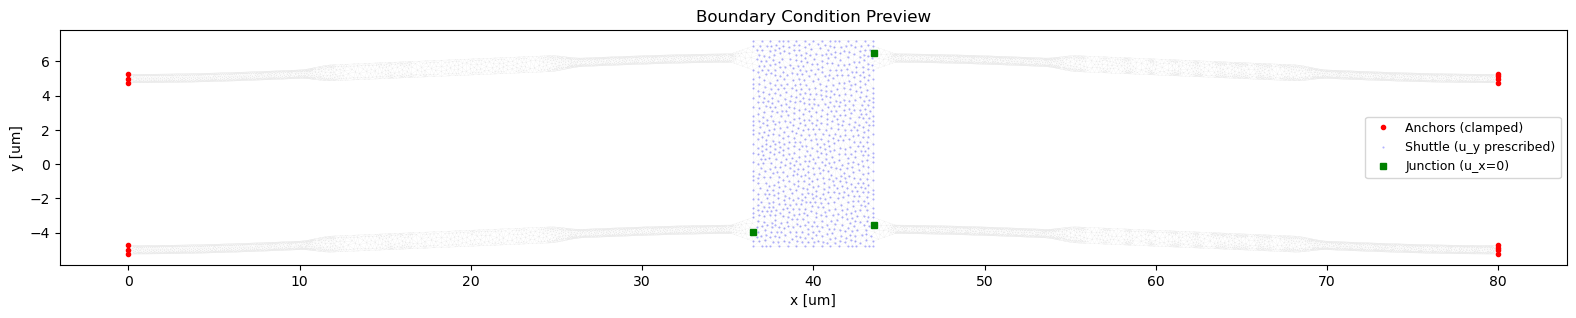

In [6]:
# Constraint preview: mesh + colored BC node overlay
fig, ax = plt.subplots(figsize=(16, 5))
ax.triplot(mesh.p[0], mesh.p[1], mesh.t.T, 'k-', alpha=0.08, linewidth=0.2)

# Anchor nodes (red)
anchor_idx = np.concatenate([bc['left_anchor'], bc['right_anchor']])
ax.plot(nodes[anchor_idx, 0], nodes[anchor_idx, 1], 'ro', ms=3, label='Anchors (clamped)', zorder=5)

# Shuttle nodes (blue)
ax.plot(nodes[bc['shuttle'], 0], nodes[bc['shuttle'], 1], 'b.', ms=1, alpha=0.3, label='Shuttle (u_y prescribed)', zorder=4)

# Junction nodes (green)
ax.plot(nodes[bc['junction'], 0], nodes[bc['junction'], 1], 'gs', ms=5, label='Junction (u_x=0)', zorder=6)

ax.set_aspect('equal')
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')
ax.set_title('Boundary Condition Preview')
ax.legend(fontsize=9)
fig.tight_layout()
fig.savefig('plots/skfem_2d_fillet_bc_preview.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Nonlinear Solver

In [7]:
max_newton = 50
nl_tol = 1e-8
n_steps = 20
delta_vals = np.linspace(0, -1.85, n_steps)
F_nl = np.zeros(n_steps)

u_current = np.zeros(ndofs)

for i, delta in enumerate(delta_vals):
    u_target = u_current.copy()
    u_target[fixed_dofs] = 0.0
    u_target[shuttle_y_dofs] = delta
    u_target[junction_x_dofs] = 0.0

    u_iter = u_target.copy()
    converged = False

    for nit in range(max_newton):
        u_field = ib.interpolate(u_iter)
        Kt = stiffness_nl.assemble(ib, prev=u_field)
        fint = internal_forces.assemble(ib, prev=u_field)

        residual = fint.copy()
        residual[all_bc] = 0.0
        res_norm = np.linalg.norm(residual)

        if res_norm < nl_tol:
            converged = True
            break

        du_corr = solve(*condense(Kt, -residual, D=all_bc))
        u_iter += du_corr

    if not converged and i > 0:
        print(f'  Step {i}: delta={delta:.4f}, not converged (res={res_norm:.2e})')

    u_current = u_iter.copy()

    u_field = ib.interpolate(u_current)
    fint = internal_forces.assemble(ib, prev=u_field)
    F_nl[i] = np.sum(fint[shuttle_y_dofs])

    if i % 5 == 0:
        print(f'  Step {i}/{n_steps}: delta={delta:.3f} um, F={F_nl[i]:.4f} uN')

print(f'Done. F range: [{F_nl.min():.4f}, {F_nl.max():.4f}] uN')

# Save CSV
np.savetxt('results/skfem_2d_full_fillet_10pct.csv',
           np.column_stack([-delta_vals, F_nl]),
           delimiter=',', header='delta_um,F_uN', comments='')
print('Saved: results/skfem_2d_full_fillet_10pct.csv')

  Step 0/20: delta=0.000 um, F=0.0000 uN
  Step 5/20: delta=-0.487 um, F=-4.8446 uN
  Step 10/20: delta=-0.974 um, F=-3.6607 uN
  Step 15/20: delta=-1.461 um, F=-0.7363 uN
Done. F range: [-4.9751, 0.0000] uN
Saved: results/skfem_2d_full_fillet_10pct.csv


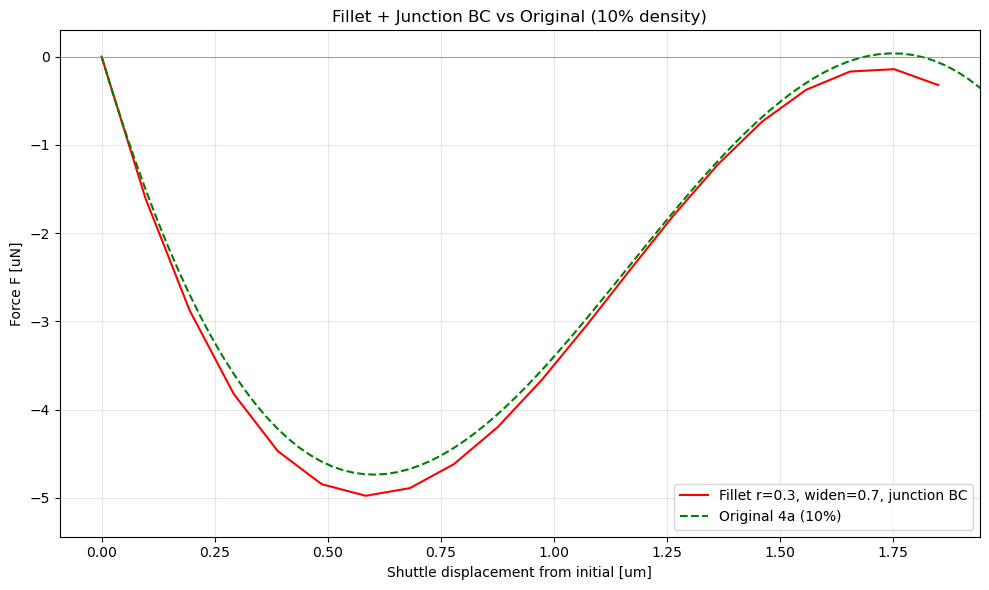

Physical range: -0.09 to 1.94 um
Trimmed F_max = 0.0000 uN
Trimmed F_min = -4.9751 uN


In [8]:
# Force-displacement: fillet vs original 4a 10%
fig, ax = plt.subplots(figsize=(10, 6))

# This run
ax.plot(-delta_vals, F_nl, 'r-', linewidth=1.5,
        label=f'Fillet r={FILLET_RADIUS}, widen={JUNCTION_WIDENING}, junction BC')

# Original 4a 10% for comparison
try:
    orig = np.loadtxt('results/skfem_2d_full_10pct.csv', delimiter=',', skiprows=1)
    ax.plot(orig[:, 0], orig[:, 1], 'g--', linewidth=1.5, label='Original 4a (10%)')
except FileNotFoundError:
    print('Original 4a 10% CSV not found; skipping comparison.')

# Auto-detect physical x-range (excludes pre-stress and post-second-well outliers)
disp_plot = -delta_vals
xlim = find_physical_xlim(disp_plot, F_nl)
ax.set_xlim(xlim)

ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlabel('Shuttle displacement from initial [um]')
ax.set_ylabel('Force F [uN]')
ax.set_title('Fillet + Junction BC vs Original (10% density)')
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig('plots/skfem_2d_fillet_vs_original.png', dpi=150, bbox_inches='tight')
plt.show()

# Trimmed statistics
mask = (disp_plot >= xlim[0]) & (disp_plot <= xlim[1])
print(f'Physical range: {xlim[0]:.2f} to {xlim[1]:.2f} um')
print(f'Trimmed F_max = {F_nl[mask].max():.4f} uN')
print(f'Trimmed F_min = {F_nl[mask].min():.4f} uN')


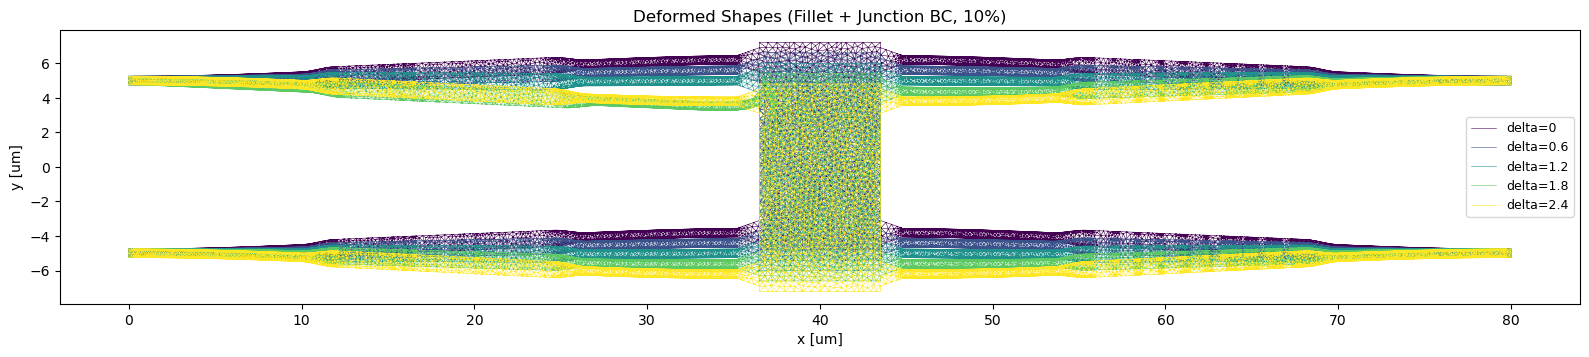

In [9]:
# Deformed shape visualization at 5 key displacements
key_deltas = [0.0, -h/2, -h, -1.5*h, -2*h]
key_labels = ['delta=0', f'delta={h/2:.1f}', f'delta={h:.1f}',
              f'delta={1.5*h:.1f}', f'delta={2*h:.1f}']

fig, ax = plt.subplots(figsize=(16, 6))
ax.triplot(mesh.p[0], mesh.p[1], mesh.t.T, 'k-', alpha=0.1, linewidth=0.2)

cmap_colors = plt.cm.viridis(np.linspace(0, 1, len(key_deltas)))

for k, (delta, label) in enumerate(zip(key_deltas, key_labels)):
    u_vis = np.zeros(ndofs)
    u_vis[shuttle_y_dofs] = delta
    u_vis[junction_x_dofs] = 0.0

    for _ in range(max_newton):
        u_field = ib.interpolate(u_vis)
        Kt = stiffness_nl.assemble(ib, prev=u_field)
        fint = internal_forces.assemble(ib, prev=u_field)
        residual = fint.copy()
        residual[all_bc] = 0.0
        if np.linalg.norm(residual) < nl_tol:
            break
        du_c = solve(*condense(Kt, -residual, D=all_bc))
        u_vis += du_c

    ux = u_vis[0::2]
    uy = u_vis[1::2]
    ax.triplot(mesh.p[0] + ux, mesh.p[1] + uy, mesh.t.T,
               '-', color=cmap_colors[k], linewidth=0.4, label=label)

ax.set_aspect('equal')
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')
ax.set_title('Deformed Shapes (Fillet + Junction BC, 10%)')
ax.legend(fontsize=9)
fig.tight_layout()
fig.savefig('plots/skfem_2d_fillet_deformed.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Flex-Ratio Sweep

Sweep `flex_ratio` to explore how the rigid-region coverage affects
bistability. Higher flex_ratio = more flexible beam = lower force but
potentially easier bistability.

In [10]:
flex_ratios = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45]
sweep_n_steps = 20
sweep_delta = np.linspace(0, -1.85, sweep_n_steps)
sweep_results = {}

for fr in flex_ratios:
    print(f'\n--- flex_ratio={fr:.2f} (rigid={1-fr:.0%}) ---')

    # Generate polygon with fillet
    poly_sw = get_full_spring_polygon(
        n_points=600,
        flex_ratio=fr,
        fillet_radius=FILLET_RADIUS,
        junction_widening=JUNCTION_WIDENING,
    )

    # Mesh
    po = poly_sw.copy()
    if np.allclose(po[0], po[-1]):
        po = po[:-1]
    nv = len(po)
    seg = np.column_stack([np.arange(nv), (np.arange(nv) + 1) % nv])
    tri_sw = tr.triangulate({'vertices': po, 'segments': seg}, f'pq30a{max_area}')
    nodes_sw = tri_sw['vertices']
    elems_sw = tri_sw['triangles']
    print(f'  Mesh: {len(nodes_sw)} nodes, {len(elems_sw)} elems')

    mesh_sw = MeshTri(
        np.ascontiguousarray(nodes_sw.T, dtype=np.float64),
        np.ascontiguousarray(elems_sw.T, dtype=np.int64),
    )
    ib_sw = Basis(mesh_sw, ElementVector(ElementTriP1()))
    N_sw = mesh_sw.nvertices
    ndofs_sw = 2 * N_sw

    # BCs
    bc_sw = identify_bc_nodes_2d(
        nodes_sw, anchor_dist, half_span, shuttle_len,
        beam_spacing=P['beam_spacing'],
        initial_offset=P['initial_offset'],
        flex_width=P['flex_width'],
    )
    lx = 2 * bc_sw['left_anchor']
    ly = 2 * bc_sw['left_anchor'] + 1
    rx = 2 * bc_sw['right_anchor']
    ry = 2 * bc_sw['right_anchor'] + 1
    fd = np.concatenate([lx, ly, rx, ry])
    sy = 2 * bc_sw['shuttle'] + 1
    jx = 2 * bc_sw['junction']
    abc = np.unique(np.concatenate([fd, sy, jx]))

    # Solve
    F_sw = np.zeros(sweep_n_steps)
    u_sw = np.zeros(ndofs_sw)

    for i, delta in enumerate(sweep_delta):
        u_t = u_sw.copy()
        u_t[fd] = 0.0
        u_t[sy] = delta
        u_t[jx] = 0.0

        u_it = u_t.copy()
        for nit in range(max_newton):
            uf = ib_sw.interpolate(u_it)
            Kt = stiffness_nl.assemble(ib_sw, prev=uf)
            fi = internal_forces.assemble(ib_sw, prev=uf)
            r = fi.copy()
            r[abc] = 0.0
            if np.linalg.norm(r) < nl_tol:
                break
            u_it += solve(*condense(Kt, -r, D=abc))

        u_sw = u_it.copy()
        uf = ib_sw.interpolate(u_sw)
        fi = internal_forces.assemble(ib_sw, prev=uf)
        F_sw[i] = np.sum(fi[sy])

    print(f'  F range: [{F_sw.min():.4f}, {F_sw.max():.4f}] uN')
    sweep_results[fr] = {'delta': -sweep_delta, 'F': F_sw}

print('\nSweep complete.')


--- flex_ratio=0.15 (rigid=85%) ---
  Mesh: 11550 nodes, 19157 elems
  F range: [-5.5685, 0.0000] uN

--- flex_ratio=0.20 (rigid=80%) ---
  Mesh: 12279 nodes, 20179 elems
  F range: [-5.3130, 0.0000] uN

--- flex_ratio=0.25 (rigid=75%) ---
  Mesh: 11359 nodes, 18545 elems
  F range: [-5.0938, 0.0000] uN

--- flex_ratio=0.30 (rigid=70%) ---
  Mesh: 11112 nodes, 18134 elems
  F range: [-4.9751, 0.0000] uN

--- flex_ratio=0.35 (rigid=65%) ---
  Mesh: 12232 nodes, 19846 elems
  F range: [-4.8745, 0.0000] uN

--- flex_ratio=0.40 (rigid=60%) ---
  Mesh: 12098 nodes, 19693 elems
  F range: [-4.8470, 0.0000] uN

--- flex_ratio=0.45 (rigid=55%) ---
  Mesh: 12879 nodes, 21015 elems
  F range: [-4.7648, 0.0000] uN

Sweep complete.


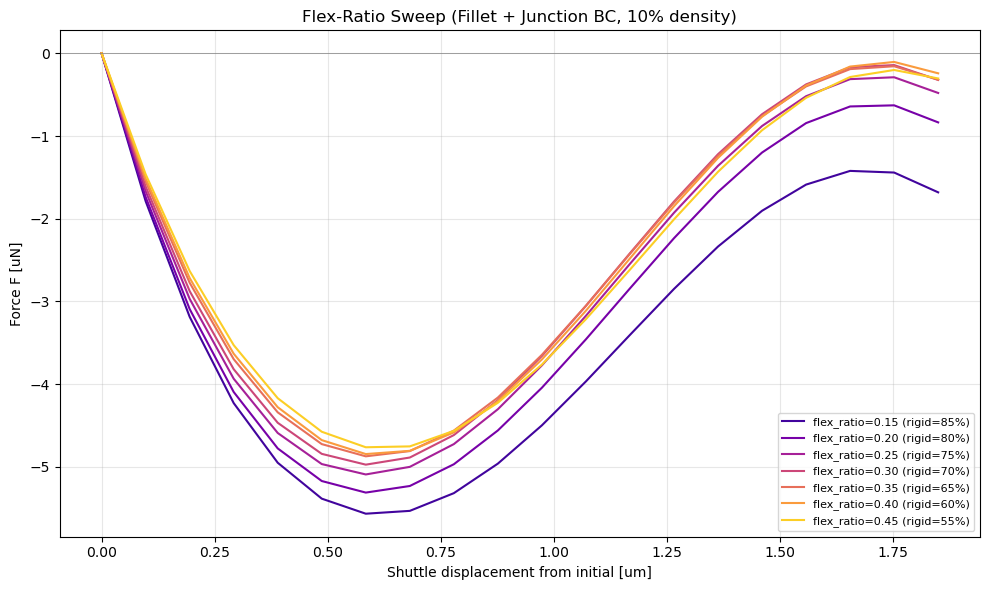

Plot x-range: -0.09 to 1.94 um


In [11]:
# Sweep overlay plot with auto-detected physical x-range
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.cm.plasma(np.linspace(0.1, 0.9, len(flex_ratios)))

# Compute union of physical ranges across all sweep runs
all_xlims = [find_physical_xlim(res['delta'], res['F'])
             for res in sweep_results.values()]
xlim_union = (min(x[0] for x in all_xlims), max(x[1] for x in all_xlims))

for idx, fr in enumerate(flex_ratios):
    res = sweep_results[fr]
    ax.plot(res['delta'], res['F'], color=cmap[idx], linewidth=1.5,
            label=f'flex_ratio={fr:.2f} (rigid={1-fr:.0%})')

ax.set_xlim(xlim_union)
ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlabel('Shuttle displacement from initial [um]')
ax.set_ylabel('Force F [uN]')
ax.set_title('Flex-Ratio Sweep (Fillet + Junction BC, 10% density)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig('plots/skfem_2d_fillet_flex_ratio_sweep.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Plot x-range: {xlim_union[0]:.2f} to {xlim_union[1]:.2f} um')


In [12]:
# Summary table (using physical range for min/max)
print(f'{"flex_ratio":>10s} {"rigid%":>6s} {"F_max [uN]":>12s} {"F_min [uN]":>12s} {"bistable?":>10s}')
print('-' * 55)
for fr in flex_ratios:
    res = sweep_results[fr]
    xlim = find_physical_xlim(res['delta'], res['F'])
    mask = (res['delta'] >= xlim[0]) & (res['delta'] <= xlim[1])
    fmax = res['F'][mask].max()
    fmin = res['F'][mask].min()
    has_positive = fmax > 0.01
    has_negative = fmin < -0.01
    bistable = 'YES' if (has_positive and has_negative) else 'no'
    print(f'{fr:10.2f} {1-fr:5.0%} {fmax:12.4f} {fmin:12.4f} {bistable:>10s}')


flex_ratio rigid%   F_max [uN]   F_min [uN]  bistable?
-------------------------------------------------------
      0.15   85%       0.0000      -5.5685         no
      0.20   80%       0.0000      -5.3130         no
      0.25   75%       0.0000      -5.0938         no
      0.30   70%       0.0000      -4.9751         no
      0.35   65%       0.0000      -4.8745         no
      0.40   60%       0.0000      -4.8470         no
      0.45   55%       0.0000      -4.7648         no


## 6. Parameter Sweeps

All sweeps use displacement range -0.2 to 2.2 um (100 steps).
Each sweep cell is independent of the others (requires cells 1 + 5 + the helper cell below).

In [13]:
# Shared sweep configuration and helper functions
SWEEP_DELTA = np.linspace(0, -1.85, 20)  # applied to shuttle nodes
SWEEP_DISP = -SWEEP_DELTA                    # displacement from initial (x-axis)
MAX_NEWTON = 50
NL_TOL = 1e-8
MESH_MAX_AREA = 0.08  # 10% density


def run_param_sweep(param_name, param_values, base_overrides=None):
    """Solve force-displacement for a sweep of one spring parameter.

    Prerequisites: cells 1 (imports/material) and 5 (nonlinear forms).
    """
    base = dict(DEFAULT_FULL_SPRING_PARAMS)
    base['fillet_radius'] = FILLET_RADIUS
    base['junction_widening'] = JUNCTION_WIDENING
    if base_overrides:
        base.update(base_overrides)

    n_steps = len(SWEEP_DELTA)
    results = {}

    for val in param_values:
        p = dict(base)
        p[param_name] = val

        # Derived geometry
        ad = p['anchor_distance']
        sl = p['shuttle_length']
        hs = (ad - sl) / 2.0

        # Generate filleted polygon
        poly = get_full_spring_polygon(
            anchor_distance=ad, beam_spacing=p['beam_spacing'],
            shuttle_length=sl, shuttle_height=p['shuttle_height'],
            flex_ratio=p['flex_ratio'], flex_width=p['flex_width'],
            rigid_width=p['rigid_width'], initial_offset=p['initial_offset'],
            taper_length=p['taper_length'], n_points=600,
            fillet_radius=p['fillet_radius'],
            junction_widening=p['junction_widening'],
        )

        # Mesh at 10% density
        po = poly[:-1] if np.allclose(poly[0], poly[-1]) else poly.copy()
        nv = len(po)
        seg = np.column_stack([np.arange(nv), (np.arange(nv) + 1) % nv])
        tri_out = tr.triangulate(
            {'vertices': po, 'segments': seg},
            f'pq30a{MESH_MAX_AREA}',
        )
        nd, el = tri_out['vertices'], tri_out['triangles']

        m = MeshTri(np.ascontiguousarray(nd.T, dtype=np.float64),
                    np.ascontiguousarray(el.T, dtype=np.int64))
        ib_loc = Basis(m, ElementVector(ElementTriP1()))
        ndofs = 2 * m.nvertices

        # Boundary conditions (with junction constraint)
        bc = identify_bc_nodes_2d(
            nd, ad, hs, sl,
            beam_spacing=p['beam_spacing'],
            initial_offset=p['initial_offset'],
            flex_width=p['flex_width'],
        )
        fd = np.concatenate([2 * bc['left_anchor'], 2 * bc['left_anchor'] + 1,
                             2 * bc['right_anchor'], 2 * bc['right_anchor'] + 1])
        sy = 2 * bc['shuttle'] + 1
        jx = 2 * bc['junction']
        abc = np.unique(np.concatenate([fd, sy, jx]))

        # Newton-Raphson incremental solve
        F_arr = np.zeros(n_steps)
        u = np.zeros(ndofs)

        for i, delta in enumerate(SWEEP_DELTA):
            ut = u.copy()
            ut[fd] = 0.0
            ut[sy] = delta
            ut[jx] = 0.0
            ui = ut.copy()

            for _ in range(MAX_NEWTON):
                uf = ib_loc.interpolate(ui)
                Kt = stiffness_nl.assemble(ib_loc, prev=uf)
                fi = internal_forces.assemble(ib_loc, prev=uf)
                r = fi.copy()
                r[abc] = 0.0
                if np.linalg.norm(r) < NL_TOL:
                    break
                ui += solve(*condense(Kt, -r, D=abc))

            u = ui.copy()
            uf = ib_loc.interpolate(u)
            fi = internal_forces.assemble(ib_loc, prev=uf)
            F_arr[i] = np.sum(fi[sy])

        results[val] = {'disp': SWEEP_DISP.copy(), 'F': F_arr, 'n_nodes': len(nd)}
        print(f'  {param_name}={val:.4g}: {len(nd)} nodes, '
              f'F=[{F_arr.min():.3f}, {F_arr.max():.3f}] uN')

    return results


def plot_sweep(results, param_name, param_unit='', title_suffix=''):
    """Overlay plot of sweep results with auto-detected physical x-range."""
    fig, ax = plt.subplots(figsize=(10, 6))
    cmap = plt.cm.plasma(np.linspace(0.1, 0.9, len(results)))
    for idx, val in enumerate(sorted(results)):
        res = results[val]
        ax.plot(res['disp'], res['F'], color=cmap[idx], linewidth=1.5,
                label=f'{param_name}={val:.4g} {param_unit}')
    # Auto x-range: union of physical ranges across all sweep runs
    all_xlims = [find_physical_xlim(r['disp'], r['F']) for r in results.values()]
    xlim = (min(x[0] for x in all_xlims), max(x[1] for x in all_xlims))
    ax.set_xlim(xlim)
    ax.axhline(0, color='gray', linewidth=0.5)
    ax.set_xlabel('Shuttle displacement from initial [um]')
    ax.set_ylabel('Force F [uN]')
    ax.set_title(f'{param_name} Sweep{title_suffix}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    return fig


def print_sweep_table(results, param_name, param_unit=''):
    """Print summary table with bistability detection (physical range only)."""
    hdr = f'{"value":>10s} {"unit":>6s} {"nodes":>7s} {"F_max":>10s} {"F_min":>10s} {"bistable":>9s}'
    print(hdr)
    print('-' * len(hdr))
    for val in sorted(results):
        res = results[val]
        xlim = find_physical_xlim(res['disp'], res['F'])
        mask = (res['disp'] >= xlim[0]) & (res['disp'] <= xlim[1])
        fmax = res['F'][mask].max() if mask.any() else res['F'].max()
        fmin = res['F'][mask].min() if mask.any() else res['F'].min()
        bi = 'YES' if (fmax > 0.01 and fmin < -0.01) else 'no'
        print(f'{val:10.4g} {param_unit:>6s} {res["n_nodes"]:7d} '
              f'{fmax:10.4f} {fmin:10.4f} {bi:>9s}')


print('Sweep helpers defined.')
print(f'Displacement range: {SWEEP_DISP[0]:.1f} to {SWEEP_DISP[-1]:.1f} um '
      f'({len(SWEEP_DISP)} steps)')

Sweep helpers defined.
Displacement range: -0.0 to 1.9 um (20 steps)


Rigid width sweep: [0.5  0.54 0.58 0.62 0.66 0.7 ] um  (flex_width=0.5 um)
  rigid_width=0.5: 10350 nodes, F=[-4.147, 0.000] uN
  rigid_width=0.54: 10600 nodes, F=[-4.236, 0.000] uN
  rigid_width=0.58: 10771 nodes, F=[-4.341, 0.000] uN
  rigid_width=0.62: 10670 nodes, F=[-4.460, 0.000] uN
  rigid_width=0.66: 10762 nodes, F=[-4.520, 0.000] uN
  rigid_width=0.7: 10738 nodes, F=[-4.595, 0.000] uN


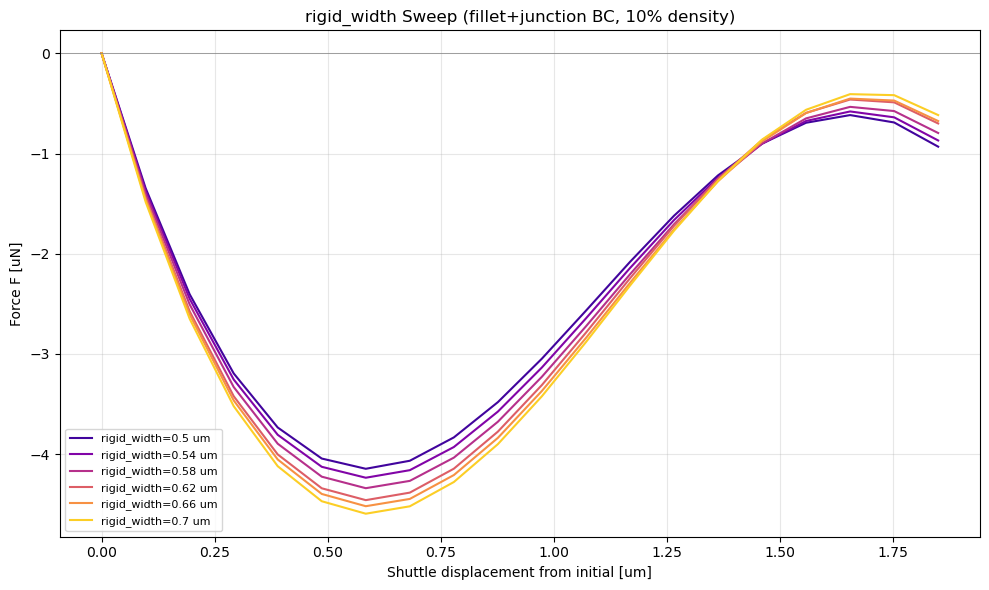


     value   unit   nodes      F_max      F_min  bistable
---------------------------------------------------------
       0.5     um   10350     0.0000    -4.1468        no
      0.54     um   10600     0.0000    -4.2361        no
      0.58     um   10771     0.0000    -4.3406        no
      0.62     um   10670     0.0000    -4.4598        no
      0.66     um   10762     0.0000    -4.5204        no
       0.7     um   10738     0.0000    -4.5952        no


In [14]:
# --- Rigid Width Sweep ---
# From same width as flex region (0.5 um) to 40% wider (0.7 um)
flex_w = P['flex_width']
rigid_widths = np.linspace(flex_w, flex_w * 1.4, 6)
print(f'Rigid width sweep: {rigid_widths.round(3)} um  (flex_width={flex_w} um)')

rw_results = run_param_sweep('rigid_width', rigid_widths)

fig = plot_sweep(rw_results, 'rigid_width', 'um',
                 ' (fillet+junction BC, 10% density)')
fig.savefig('plots/skfem_2d_sweep_rigid_width.png', dpi=150, bbox_inches='tight')
plt.show()

print()
print_sweep_table(rw_results, 'rigid_width', 'um')

Apex height sweep: [0.5  0.75 1.   1.2  1.5  1.75 2.  ] um
  Bistability threshold Q > 2.31 => h > 1.16 um  (t=0.5 um)
  initial_offset=0.5: 11492 nodes, F=[-16.698, 0.000] uN
  initial_offset=0.75: 10955 nodes, F=[-8.751, 0.000] uN
  initial_offset=1: 11538 nodes, F=[-3.204, 0.000] uN
  initial_offset=1.2: 11112 nodes, F=[-4.975, 0.000] uN
  initial_offset=1.5: 10896 nodes, F=[-8.885, 1.138] uN
  initial_offset=1.75: 11659 nodes, F=[-13.351, 0.000] uN
  initial_offset=2: 11652 nodes, F=[-18.528, 0.000] uN


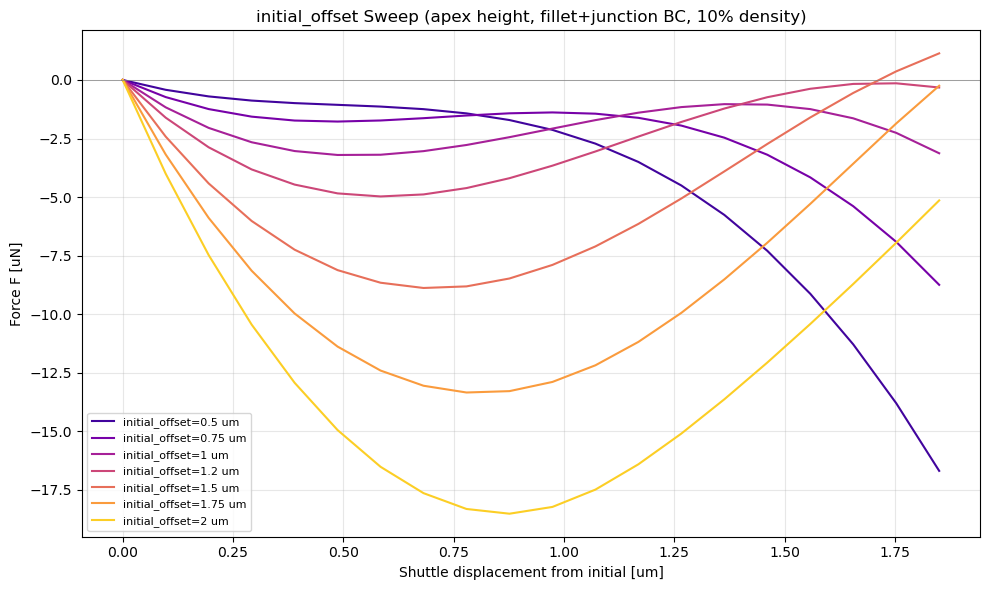


     value   unit   nodes      F_max      F_min  bistable
---------------------------------------------------------
       0.5     um   11492     0.0000   -16.6980        no
      0.75     um   10955     0.0000    -8.7506        no
         1     um   11538     0.0000    -3.2035        no
       1.2     um   11112     0.0000    -4.9751        no
       1.5     um   10896     0.3685    -8.8854       YES
      1.75     um   11659     0.0000   -13.3506        no
         2     um   11652     0.0000   -18.5281        no


In [15]:
# --- Apex Height (initial_offset) Sweep ---
apex_heights = np.array([0.5, 0.75, 1.0, 1.2, 1.5, 1.75, 2.0])
print(f'Apex height sweep: {apex_heights} um')
print(f'  Bistability threshold Q > 2.31 => h > {2.31 * t:.2f} um  (t={t} um)')

ah_results = run_param_sweep('initial_offset', apex_heights)

fig = plot_sweep(ah_results, 'initial_offset', 'um',
                 ' (apex height, fillet+junction BC, 10% density)')
fig.savefig('plots/skfem_2d_sweep_apex_height.png', dpi=150, bbox_inches='tight')
plt.show()

print()
print_sweep_table(ah_results, 'initial_offset', 'um')

Span sweep: [ 60.  70.  80.  90. 100. 110. 120.] um
  anchor_distance=60: 12173 nodes, F=[-12.928, 0.000] uN
  anchor_distance=70: 11366 nodes, F=[-7.680, 0.000] uN
  anchor_distance=80: 11112 nodes, F=[-4.975, 0.000] uN
  anchor_distance=90: 10487 nodes, F=[-3.392, 0.000] uN
  anchor_distance=100: 10448 nodes, F=[-2.420, 0.000] uN
  anchor_distance=110: 10717 nodes, F=[-1.763, 0.000] uN
  anchor_distance=120: 9510 nodes, F=[-1.336, 0.000] uN


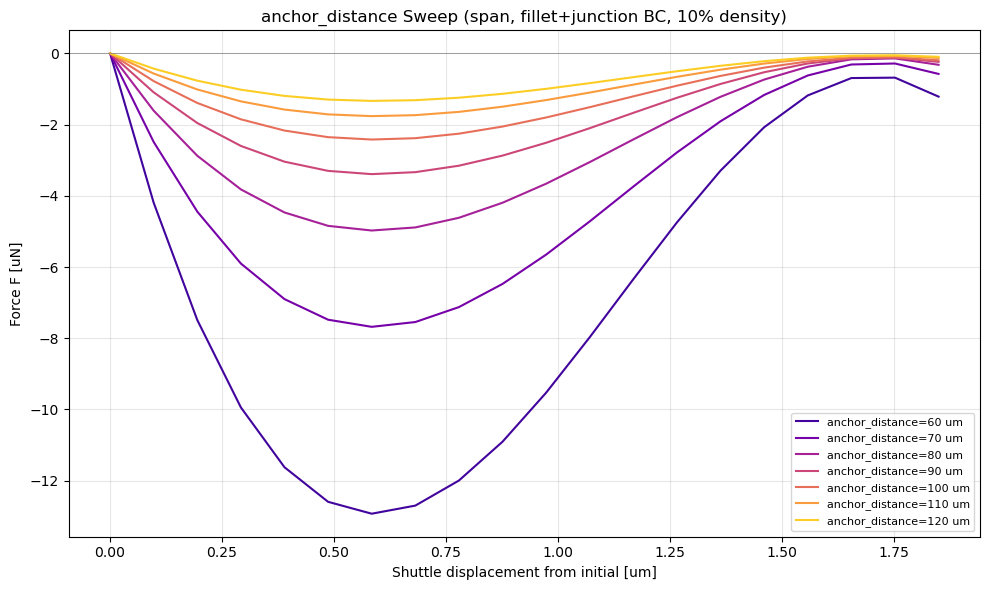


     value   unit   nodes      F_max      F_min  bistable
---------------------------------------------------------
        60     um   12173     0.0000   -12.9281        no
        70     um   11366     0.0000    -7.6800        no
        80     um   11112     0.0000    -4.9751        no
        90     um   10487     0.0000    -3.3919        no
       100     um   10448     0.0000    -2.4204        no
       110     um   10717     0.0000    -1.7630        no
       120     um    9510     0.0000    -1.3356        no


In [16]:
# --- Spring Span (anchor_distance) Sweep ---
span_values = np.array([60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0])
print(f'Span sweep: {span_values} um')

sp_results = run_param_sweep('anchor_distance', span_values)

fig = plot_sweep(sp_results, 'anchor_distance', 'um',
                 ' (span, fillet+junction BC, 10% density)')
fig.savefig('plots/skfem_2d_sweep_span.png', dpi=150, bbox_inches='tight')
plt.show()

print()
print_sweep_table(sp_results, 'anchor_distance', 'um')

## 7. Sandbox -- Single Forward Simulation

Duplicate this cell to test parameter combinations informed by the 1D sweeps above.
Edit the parameter block at the top, run, and compare F-d curves across copies.

Q = h/t = 1.5/0.5 = 3.00  (bistable threshold ~2.31)
half_span = 46.5 um
Mesh: 12170 nodes, 19669 triangles
BCs: 6+6 anchor, 881 shuttle, 0 junction


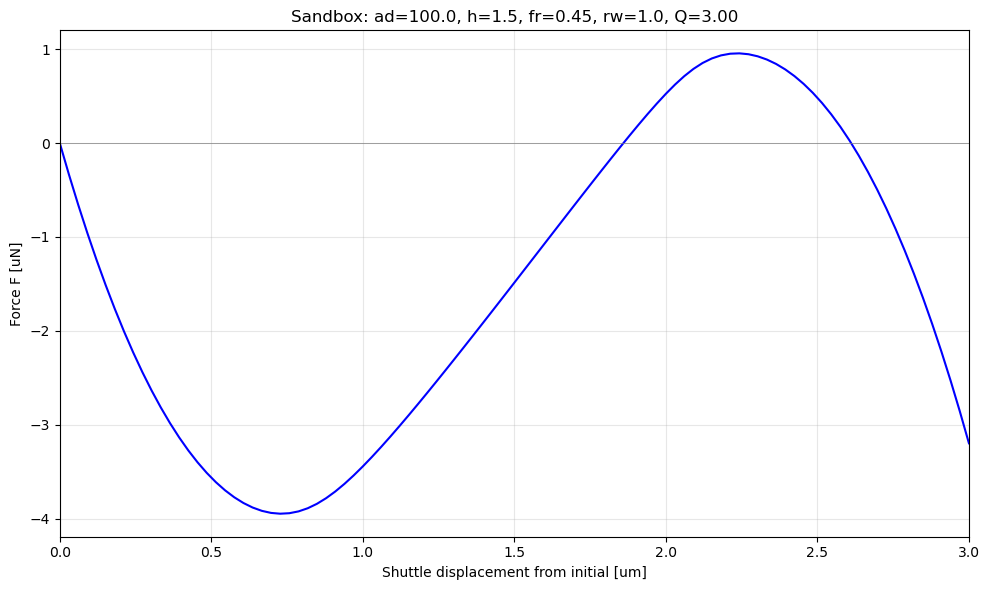

F_max = +0.9558 uN,  F_min = -3.9473 uN
Bistable: YES
Plot x-range: 0.00 to 3.00 um


In [37]:
# ========== EDIT PARAMETERS HERE ==========
sandbox_params = dict(
    # Geometry -- swept in sections 5 & 6
    anchor_distance  = 100.00,    # um  (swept: 60-120)
    initial_offset   = 1.50,     # um  apex height (swept: 0.5-2.0, bistable threshold ~1.16)
    flex_ratio       = 0.45,    # fraction  (swept: 0.15-0.45)
    rigid_width      = 1.00,  # um  (swept: 0.5-0.7)

    # Geometry -- fixed in sweeps, editable here
    beam_spacing     = 10.0,    # um  gap between upper/lower beams
    shuttle_length   = 7.0,     # um
    shuttle_height   = 12.0,    # um
    flex_width       = 0.5,     # um  beam width in flex region
    taper_length     = 2.0,     # um  rigid-to-flex transition

    # Fillet & junction
    fillet_radius       = 0.3,  # um  (capped internally to flex_width/2 - 0.02)
    junction_widening   = 0.7,  # um  triangular gusset half-width at shuttle face
)

# Solver settings
n_steps   = 100        # displacement increments (more = smoother curve)
delta_max = -3.0      # um  max shuttle displacement (negative = downward)
max_area  = 0.08      # mesh density (smaller = finer, 0.08 ~ 10%)

# Plot settings
plot_xlim = (0,3.0)      # None = auto-detect, or set e.g. (-0.2, 2.2)
# ===========================================

# --- Derived quantities ---
sb = sandbox_params
ad = sb['anchor_distance']
sl = sb['shuttle_length']
hs = (ad - sl) / 2.0
Q  = sb['initial_offset'] / sb['flex_width']
print(f'Q = h/t = {sb["initial_offset"]}/{sb["flex_width"]} = {Q:.2f}  '
      f'(bistable threshold ~2.31)')
print(f'half_span = {hs:.1f} um')

# --- Geometry ---
poly_sb = get_full_spring_polygon(
    anchor_distance=ad, beam_spacing=sb['beam_spacing'],
    shuttle_length=sl, shuttle_height=sb['shuttle_height'],
    flex_ratio=sb['flex_ratio'], flex_width=sb['flex_width'],
    rigid_width=sb['rigid_width'], initial_offset=sb['initial_offset'],
    taper_length=sb['taper_length'], n_points=600,
    fillet_radius=sb['fillet_radius'],
    junction_widening=sb['junction_widening'],
)

# --- Mesh ---
po = poly_sb[:-1] if np.allclose(poly_sb[0], poly_sb[-1]) else poly_sb.copy()
nv = len(po)
seg = np.column_stack([np.arange(nv), (np.arange(nv) + 1) % nv])
tri_sb = tr.triangulate({'vertices': po, 'segments': seg}, f'pq30a{max_area}')
nd, el = tri_sb['vertices'], tri_sb['triangles']
m_sb = MeshTri(np.ascontiguousarray(nd.T, dtype=np.float64),
               np.ascontiguousarray(el.T, dtype=np.int64))
ib_sb = Basis(m_sb, ElementVector(ElementTriP1()))
ndofs_sb = 2 * m_sb.nvertices
print(f'Mesh: {len(nd)} nodes, {len(el)} triangles')

# --- Boundary conditions ---
bc_sb = identify_bc_nodes_2d(
    nd, ad, hs, sl,
    beam_spacing=sb['beam_spacing'],
    initial_offset=sb['initial_offset'],
    flex_width=sb['flex_width'],
)
fd_sb = np.concatenate([2*bc_sb['left_anchor'], 2*bc_sb['left_anchor']+1,
                         2*bc_sb['right_anchor'], 2*bc_sb['right_anchor']+1])
sy_sb = 2 * bc_sb['shuttle'] + 1
jx_sb = 2 * bc_sb['junction']
abc_sb = np.unique(np.concatenate([fd_sb, sy_sb, jx_sb]))
print(f'BCs: {len(bc_sb["left_anchor"])}+{len(bc_sb["right_anchor"])} anchor, '
      f'{len(bc_sb["shuttle"])} shuttle, {len(bc_sb["junction"])} junction')

# --- Incremental Newton-Raphson solve ---
delta_sb = np.linspace(0, delta_max, n_steps)
F_sb = np.zeros(n_steps)
u_sb = np.zeros(ndofs_sb)

for i, delta in enumerate(delta_sb):
    ut = u_sb.copy()
    ut[fd_sb] = 0.0;  ut[sy_sb] = delta;  ut[jx_sb] = 0.0
    ui = ut.copy()
    for _ in range(50):
        uf = ib_sb.interpolate(ui)
        Kt = stiffness_nl.assemble(ib_sb, prev=uf)
        fi = internal_forces.assemble(ib_sb, prev=uf)
        r = fi.copy();  r[abc_sb] = 0.0
        if np.linalg.norm(r) < 1e-8:
            break
        ui += solve(*condense(Kt, -r, D=abc_sb))
    u_sb = ui.copy()
    uf = ib_sb.interpolate(u_sb)
    fi = internal_forces.assemble(ib_sb, prev=uf)
    F_sb[i] = np.sum(fi[sy_sb])

disp_sb = -delta_sb

# --- Results ---
xlim = plot_xlim if plot_xlim is not None else find_physical_xlim(disp_sb, F_sb)
mask = (disp_sb >= xlim[0]) & (disp_sb <= xlim[1])
fmax = F_sb[mask].max() if mask.any() else F_sb.max()
fmin = F_sb[mask].min() if mask.any() else F_sb.min()
bistable = (fmax > 0.01) and (fmin < -0.01)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(disp_sb, F_sb, 'b-', linewidth=1.5)
ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_xlabel('Shuttle displacement from initial [um]')
ax.set_ylabel('Force F [uN]')
ax.set_title(f'Sandbox: ad={ad}, h={sb["initial_offset"]}, fr={sb["flex_ratio"]}, '
             f'rw={sb["rigid_width"]}, Q={Q:.2f}')
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

print(f'F_max = {fmax:+.4f} uN,  F_min = {fmin:+.4f} uN')
print(f'Bistable: {"YES" if bistable else "no"}')
print(f'Plot x-range: {xlim[0]:.2f} to {xlim[1]:.2f} um'
      f'{" (auto)" if plot_xlim is None else ""}')

Q = h/t = 2.0/0.5 = 4.00  (bistable threshold ~2.31)
half_span = 56.5 um
Mesh: 10256 nodes, 16323 triangles
BCs: 6+6 anchor, 878 shuttle, 6 junction


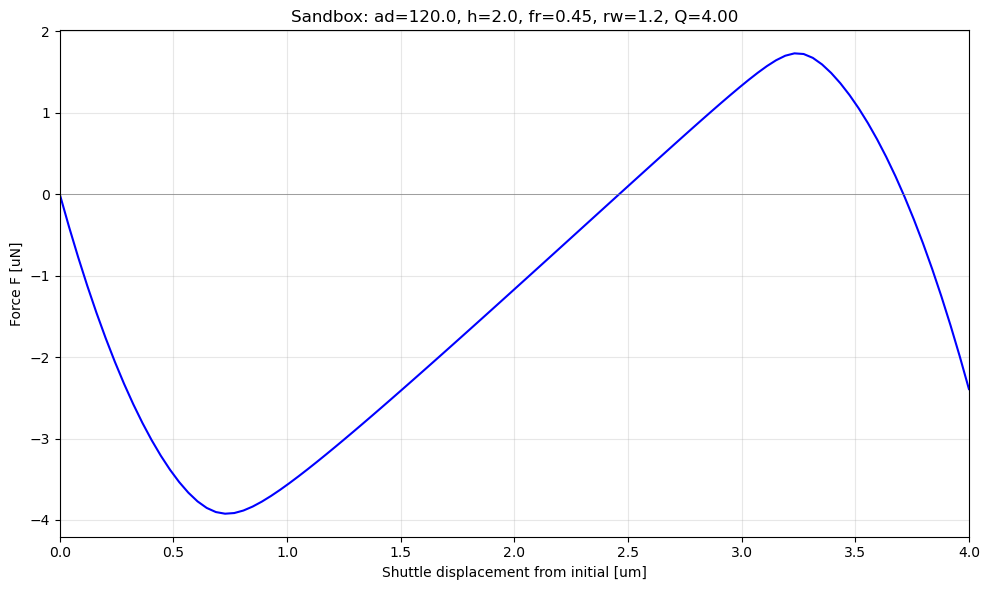

F_max = +1.7308 uN,  F_min = -3.9237 uN
Bistable: YES
Plot x-range: 0.00 to 4.00 um


In [39]:
# ========== EDIT PARAMETERS HERE ==========
sandbox_params = dict(
    # Geometry -- swept in sections 5 & 6
    anchor_distance  = 120.00,    # um  (swept: 60-120)
    initial_offset   = 2.00,     # um  apex height (swept: 0.5-2.0, bistable threshold ~1.16)
    flex_ratio       = 0.45,    # fraction  (swept: 0.15-0.45)
    rigid_width      = 1.20,    # um  (swept: 0.5-0.7)

    # Geometry -- fixed in sweeps, editable here
    beam_spacing     = 10.0,    # um  gap between upper/lower beams
    shuttle_length   = 7.0,     # um
    shuttle_height   = 12.0,    # um
    flex_width       = 0.5,     # um  beam width in flex region
    taper_length     = 2.0,     # um  rigid-to-flex transition

    # Fillet & junction
    fillet_radius       = 0.3,  # um  (capped internally to flex_width/2 - 0.02)
    junction_widening   = 0.7,  # um  triangular gusset half-width at shuttle face
)

# Solver settings
n_steps   = 100        # displacement increments (more = smoother curve)
delta_max = -4      # um  max shuttle displacement (negative = downward)
max_area  = 0.08      # mesh density (smaller = finer, 0.08 ~ 10%)

# Plot settings
plot_xlim = (0,-delta_max)      # None = auto-detect, or set e.g. (-0.2, 2.2)
# ===========================================

# --- Derived quantities ---
sb = sandbox_params
ad = sb['anchor_distance']
sl = sb['shuttle_length']
hs = (ad - sl) / 2.0
Q  = sb['initial_offset'] / sb['flex_width']
print(f'Q = h/t = {sb["initial_offset"]}/{sb["flex_width"]} = {Q:.2f}  '
      f'(bistable threshold ~2.31)')
print(f'half_span = {hs:.1f} um')

# --- Geometry ---
poly_sb = get_full_spring_polygon(
    anchor_distance=ad, beam_spacing=sb['beam_spacing'],
    shuttle_length=sl, shuttle_height=sb['shuttle_height'],
    flex_ratio=sb['flex_ratio'], flex_width=sb['flex_width'],
    rigid_width=sb['rigid_width'], initial_offset=sb['initial_offset'],
    taper_length=sb['taper_length'], n_points=600,
    fillet_radius=sb['fillet_radius'],
    junction_widening=sb['junction_widening'],
)

# --- Mesh ---
po = poly_sb[:-1] if np.allclose(poly_sb[0], poly_sb[-1]) else poly_sb.copy()
nv = len(po)
seg = np.column_stack([np.arange(nv), (np.arange(nv) + 1) % nv])
tri_sb = tr.triangulate({'vertices': po, 'segments': seg}, f'pq30a{max_area}')
nd, el = tri_sb['vertices'], tri_sb['triangles']
m_sb = MeshTri(np.ascontiguousarray(nd.T, dtype=np.float64),
               np.ascontiguousarray(el.T, dtype=np.int64))
ib_sb = Basis(m_sb, ElementVector(ElementTriP1()))
ndofs_sb = 2 * m_sb.nvertices
print(f'Mesh: {len(nd)} nodes, {len(el)} triangles')

# --- Boundary conditions ---
bc_sb = identify_bc_nodes_2d(
    nd, ad, hs, sl,
    beam_spacing=sb['beam_spacing'],
    initial_offset=sb['initial_offset'],
    flex_width=sb['flex_width'],
)
fd_sb = np.concatenate([2*bc_sb['left_anchor'], 2*bc_sb['left_anchor']+1,
                         2*bc_sb['right_anchor'], 2*bc_sb['right_anchor']+1])
sy_sb = 2 * bc_sb['shuttle'] + 1
jx_sb = 2 * bc_sb['junction']
abc_sb = np.unique(np.concatenate([fd_sb, sy_sb, jx_sb]))
print(f'BCs: {len(bc_sb["left_anchor"])}+{len(bc_sb["right_anchor"])} anchor, '
      f'{len(bc_sb["shuttle"])} shuttle, {len(bc_sb["junction"])} junction')

# --- Incremental Newton-Raphson solve ---
delta_sb = np.linspace(0, delta_max, n_steps)
F_sb = np.zeros(n_steps)
u_sb = np.zeros(ndofs_sb)

for i, delta in enumerate(delta_sb):
    ut = u_sb.copy()
    ut[fd_sb] = 0.0;  ut[sy_sb] = delta;  ut[jx_sb] = 0.0
    ui = ut.copy()
    for _ in range(50):
        uf = ib_sb.interpolate(ui)
        Kt = stiffness_nl.assemble(ib_sb, prev=uf)
        fi = internal_forces.assemble(ib_sb, prev=uf)
        r = fi.copy();  r[abc_sb] = 0.0
        if np.linalg.norm(r) < 1e-8:
            break
        ui += solve(*condense(Kt, -r, D=abc_sb))
    u_sb = ui.copy()
    uf = ib_sb.interpolate(u_sb)
    fi = internal_forces.assemble(ib_sb, prev=uf)
    F_sb[i] = np.sum(fi[sy_sb])

disp_sb = -delta_sb

# --- Results ---
xlim = plot_xlim if plot_xlim is not None else find_physical_xlim(disp_sb, F_sb)
mask = (disp_sb >= xlim[0]) & (disp_sb <= xlim[1])
fmax = F_sb[mask].max() if mask.any() else F_sb.max()
fmin = F_sb[mask].min() if mask.any() else F_sb.min()
bistable = (fmax > 0.01) and (fmin < -0.01)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(disp_sb, F_sb, 'b-', linewidth=1.5)
ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_xlabel('Shuttle displacement from initial [um]')
ax.set_ylabel('Force F [uN]')
ax.set_title(f'Sandbox: ad={ad}, h={sb["initial_offset"]}, fr={sb["flex_ratio"]}, '
             f'rw={sb["rigid_width"]}, Q={Q:.2f}')
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

print(f'F_max = {fmax:+.4f} uN,  F_min = {fmin:+.4f} uN')
print(f'Bistable: {"YES" if bistable else "no"}')
print(f'Plot x-range: {xlim[0]:.2f} to {xlim[1]:.2f} um'
      f'{" (auto)" if plot_xlim is None else ""}')

Q = h/t = 2.0/0.5 = 4.00  (bistable threshold ~2.31)
half_span = 56.5 um
Mesh: 10073 nodes, 15982 triangles
BCs: 6+6 anchor, 867 shuttle, 6 junction


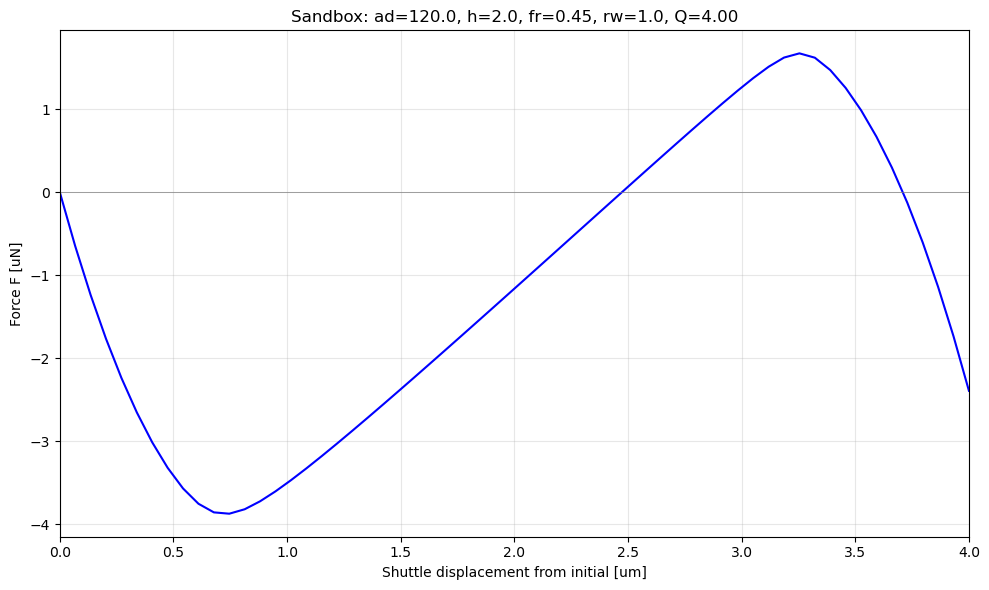

F_max = +1.6705 uN,  F_min = -3.8702 uN
Bistable: YES
Plot x-range: 0.00 to 4.00 um


In [36]:
# ========== EDIT PARAMETERS HERE ==========
sandbox_params = dict(
    # Geometry -- swept in sections 5 & 6
    anchor_distance  = 120.00,    # um  (swept: 60-120)
    initial_offset   = 2.00,     # um  apex height (swept: 0.5-2.0, bistable threshold ~1.16)
    flex_ratio       = 0.45,    # fraction  (swept: 0.15-0.45)
    rigid_width      = 1.00,    # um  (swept: 0.5-0.7)

    # Geometry -- fixed in sweeps, editable here
    beam_spacing     = 10.0,    # um  gap between upper/lower beams
    shuttle_length   = 7.0,     # um
    shuttle_height   = 12.0,    # um
    flex_width       = 0.5,     # um  beam width in flex region
    taper_length     = 2.0,     # um  rigid-to-flex transition

    # Fillet & junction
    fillet_radius       = 0.3,  # um  (capped internally to flex_width/2 - 0.02)
    junction_widening   = 0.7,  # um  triangular gusset half-width at shuttle face
)

# Solver settings
n_steps   = 60        # displacement increments (more = smoother curve)
delta_max = -4      # um  max shuttle displacement (negative = downward)
max_area  = 0.08      # mesh density (smaller = finer, 0.08 ~ 10%)

# Plot settings
plot_xlim = (0,-delta_max)      # None = auto-detect, or set e.g. (-0.2, 2.2)
# ===========================================

# --- Derived quantities ---
sb = sandbox_params
ad = sb['anchor_distance']
sl = sb['shuttle_length']
hs = (ad - sl) / 2.0
Q  = sb['initial_offset'] / sb['flex_width']
print(f'Q = h/t = {sb["initial_offset"]}/{sb["flex_width"]} = {Q:.2f}  '
      f'(bistable threshold ~2.31)')
print(f'half_span = {hs:.1f} um')

# --- Geometry ---
poly_sb = get_full_spring_polygon(
    anchor_distance=ad, beam_spacing=sb['beam_spacing'],
    shuttle_length=sl, shuttle_height=sb['shuttle_height'],
    flex_ratio=sb['flex_ratio'], flex_width=sb['flex_width'],
    rigid_width=sb['rigid_width'], initial_offset=sb['initial_offset'],
    taper_length=sb['taper_length'], n_points=600,
    fillet_radius=sb['fillet_radius'],
    junction_widening=sb['junction_widening'],
)

# --- Mesh ---
po = poly_sb[:-1] if np.allclose(poly_sb[0], poly_sb[-1]) else poly_sb.copy()
nv = len(po)
seg = np.column_stack([np.arange(nv), (np.arange(nv) + 1) % nv])
tri_sb = tr.triangulate({'vertices': po, 'segments': seg}, f'pq30a{max_area}')
nd, el = tri_sb['vertices'], tri_sb['triangles']
m_sb = MeshTri(np.ascontiguousarray(nd.T, dtype=np.float64),
               np.ascontiguousarray(el.T, dtype=np.int64))
ib_sb = Basis(m_sb, ElementVector(ElementTriP1()))
ndofs_sb = 2 * m_sb.nvertices
print(f'Mesh: {len(nd)} nodes, {len(el)} triangles')

# --- Boundary conditions ---
bc_sb = identify_bc_nodes_2d(
    nd, ad, hs, sl,
    beam_spacing=sb['beam_spacing'],
    initial_offset=sb['initial_offset'],
    flex_width=sb['flex_width'],
)
fd_sb = np.concatenate([2*bc_sb['left_anchor'], 2*bc_sb['left_anchor']+1,
                         2*bc_sb['right_anchor'], 2*bc_sb['right_anchor']+1])
sy_sb = 2 * bc_sb['shuttle'] + 1
jx_sb = 2 * bc_sb['junction']
abc_sb = np.unique(np.concatenate([fd_sb, sy_sb, jx_sb]))
print(f'BCs: {len(bc_sb["left_anchor"])}+{len(bc_sb["right_anchor"])} anchor, '
      f'{len(bc_sb["shuttle"])} shuttle, {len(bc_sb["junction"])} junction')

# --- Incremental Newton-Raphson solve ---
delta_sb = np.linspace(0, delta_max, n_steps)
F_sb = np.zeros(n_steps)
u_sb = np.zeros(ndofs_sb)

for i, delta in enumerate(delta_sb):
    ut = u_sb.copy()
    ut[fd_sb] = 0.0;  ut[sy_sb] = delta;  ut[jx_sb] = 0.0
    ui = ut.copy()
    for _ in range(50):
        uf = ib_sb.interpolate(ui)
        Kt = stiffness_nl.assemble(ib_sb, prev=uf)
        fi = internal_forces.assemble(ib_sb, prev=uf)
        r = fi.copy();  r[abc_sb] = 0.0
        if np.linalg.norm(r) < 1e-8:
            break
        ui += solve(*condense(Kt, -r, D=abc_sb))
    u_sb = ui.copy()
    uf = ib_sb.interpolate(u_sb)
    fi = internal_forces.assemble(ib_sb, prev=uf)
    F_sb[i] = np.sum(fi[sy_sb])

disp_sb = -delta_sb

# --- Results ---
xlim = plot_xlim if plot_xlim is not None else find_physical_xlim(disp_sb, F_sb)
mask = (disp_sb >= xlim[0]) & (disp_sb <= xlim[1])
fmax = F_sb[mask].max() if mask.any() else F_sb.max()
fmin = F_sb[mask].min() if mask.any() else F_sb.min()
bistable = (fmax > 0.01) and (fmin < -0.01)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(disp_sb, F_sb, 'b-', linewidth=1.5)
ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_xlabel('Shuttle displacement from initial [um]')
ax.set_ylabel('Force F [uN]')
ax.set_title(f'Sandbox: ad={ad}, h={sb["initial_offset"]}, fr={sb["flex_ratio"]}, '
             f'rw={sb["rigid_width"]}, Q={Q:.2f}')
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

print(f'F_max = {fmax:+.4f} uN,  F_min = {fmin:+.4f} uN')
print(f'Bistable: {"YES" if bistable else "no"}')
print(f'Plot x-range: {xlim[0]:.2f} to {xlim[1]:.2f} um'
      f'{" (auto)" if plot_xlim is None else ""}')

In [ ]:
# ========== EDIT PARAMETERS HERE ==========
sandbox_params = dict(
    # Geometry -- swept in sections 5 & 6
    anchor_distance  = 120.00,    # um  (swept: 60-120)
    initial_offset   = 2.00,     # um  apex height (swept: 0.5-2.0, bistable threshold ~1.16)
    flex_ratio       = 0.45,    # fraction  (swept: 0.15-0.45)
    rigid_width      = 1.00,    # um  (swept: 0.5-0.7)

    # Geometry -- fixed in sweeps, editable here
    beam_spacing     = 10.0,    # um  gap between upper/lower beams
    shuttle_length   = 7.0,     # um
    shuttle_height   = 12.0,    # um
    flex_width       = 0.5,     # um  beam width in flex region
    taper_length     = 2.0,     # um  rigid-to-flex transition

    # Fillet & junction
    fillet_radius       = 0.3,  # um  (capped internally to flex_width/2 - 0.02)
    junction_widening   = 0.7,  # um  triangular gusset half-width at shuttle face
)

# Solver settings
n_steps   = 60        # displacement increments (more = smoother curve)
delta_max = -4      # um  max shuttle displacement (negative = downward)
max_area  = 0.08      # mesh density (smaller = finer, 0.08 ~ 10%)

# Plot settings
plot_xlim = (0,-delta_max)      # None = auto-detect, or set e.g. (-0.2, 2.2)
# ===========================================

# --- Derived quantities ---
sb = sandbox_params
ad = sb['anchor_distance']
sl = sb['shuttle_length']
hs = (ad - sl) / 2.0
Q  = sb['initial_offset'] / sb['flex_width']
print(f'Q = h/t = {sb["initial_offset"]}/{sb["flex_width"]} = {Q:.2f}  '
      f'(bistable threshold ~2.31)')
print(f'half_span = {hs:.1f} um')

# --- Geometry ---
poly_sb = get_full_spring_polygon(
    anchor_distance=ad, beam_spacing=sb['beam_spacing'],
    shuttle_length=sl, shuttle_height=sb['shuttle_height'],
    flex_ratio=sb['flex_ratio'], flex_width=sb['flex_width'],
    rigid_width=sb['rigid_width'], initial_offset=sb['initial_offset'],
    taper_length=sb['taper_length'], n_points=600,
    fillet_radius=sb['fillet_radius'],
    junction_widening=sb['junction_widening'],
)

# --- Mesh ---
po = poly_sb[:-1] if np.allclose(poly_sb[0], poly_sb[-1]) else poly_sb.copy()
nv = len(po)
seg = np.column_stack([np.arange(nv), (np.arange(nv) + 1) % nv])
tri_sb = tr.triangulate({'vertices': po, 'segments': seg}, f'pq30a{max_area}')
nd, el = tri_sb['vertices'], tri_sb['triangles']
m_sb = MeshTri(np.ascontiguousarray(nd.T, dtype=np.float64),
               np.ascontiguousarray(el.T, dtype=np.int64))
ib_sb = Basis(m_sb, ElementVector(ElementTriP1()))
ndofs_sb = 2 * m_sb.nvertices
print(f'Mesh: {len(nd)} nodes, {len(el)} triangles')

# --- Boundary conditions ---
bc_sb = identify_bc_nodes_2d(
    nd, ad, hs, sl,
    beam_spacing=sb['beam_spacing'],
    initial_offset=sb['initial_offset'],
    flex_width=sb['flex_width'],
)
fd_sb = np.concatenate([2*bc_sb['left_anchor'], 2*bc_sb['left_anchor']+1,
                         2*bc_sb['right_anchor'], 2*bc_sb['right_anchor']+1])
sy_sb = 2 * bc_sb['shuttle'] + 1
jx_sb = 2 * bc_sb['junction']
abc_sb = np.unique(np.concatenate([fd_sb, sy_sb, jx_sb]))
print(f'BCs: {len(bc_sb["left_anchor"])}+{len(bc_sb["right_anchor"])} anchor, '
      f'{len(bc_sb["shuttle"])} shuttle, {len(bc_sb["junction"])} junction')

# --- Incremental Newton-Raphson solve ---
delta_sb = np.linspace(0, delta_max, n_steps)
F_sb = np.zeros(n_steps)
u_sb = np.zeros(ndofs_sb)

for i, delta in enumerate(delta_sb):
    ut = u_sb.copy()
    ut[fd_sb] = 0.0;  ut[sy_sb] = delta;  ut[jx_sb] = 0.0
    ui = ut.copy()
    for _ in range(50):
        uf = ib_sb.interpolate(ui)
        Kt = stiffness_nl.assemble(ib_sb, prev=uf)
        fi = internal_forces.assemble(ib_sb, prev=uf)
        r = fi.copy();  r[abc_sb] = 0.0
        if np.linalg.norm(r) < 1e-8:
            break
        ui += solve(*condense(Kt, -r, D=abc_sb))
    u_sb = ui.copy()
    uf = ib_sb.interpolate(u_sb)
    fi = internal_forces.assemble(ib_sb, prev=uf)
    F_sb[i] = np.sum(fi[sy_sb])

disp_sb = -delta_sb

# --- Results ---
xlim = plot_xlim if plot_xlim is not None else find_physical_xlim(disp_sb, F_sb)
mask = (disp_sb >= xlim[0]) & (disp_sb <= xlim[1])
fmax = F_sb[mask].max() if mask.any() else F_sb.max()
fmin = F_sb[mask].min() if mask.any() else F_sb.min()
bistable = (fmax > 0.01) and (fmin < -0.01)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(disp_sb, F_sb, 'b-', linewidth=1.5)
ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_xlabel('Shuttle displacement from initial [um]')
ax.set_ylabel('Force F [uN]')
ax.set_title(f'Sandbox: ad={ad}, h={sb["initial_offset"]}, fr={sb["flex_ratio"]}, '
             f'rw={sb["rigid_width"]}, Q={Q:.2f}')
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

print(f'F_max = {fmax:+.4f} uN,  F_min = {fmin:+.4f} uN')
print(f'Bistable: {"YES" if bistable else "no"}')
print(f'Plot x-range: {xlim[0]:.2f} to {xlim[1]:.2f} um'
      f'{" (auto)" if plot_xlim is None else ""}')

## 8. GDS Export -- Verified Component

Generate a GDSFactory component from the FEM-verified merged polygon.
Uses the exact fused geometry (beams + shuttle + fillets + gussets) from
`get_full_spring_polygon()` on POLY_MEMS, with rectangular anchor pads
on POLY_ANCHOR and SI_FULL at the clamped ends.

The cell defines `make_verified_bistable_spring()` which can be imported
into other GDSFactory designs.

In [ ]:
import inspect
import gdsfactory as gf

sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath('__file__')), '../libraries'))
from mcw_custom_optical_mems_pdk import LAYER, PDK
PDK.activate()

VERIFIED_DIR = os.path.join(os.path.dirname(os.path.abspath('__file__')),
                            '../components/verified')
os.makedirs(VERIFIED_DIR, exist_ok=True)


@gf.cell
def make_verified_bistable_spring(
    # Geometry (same parameters as sandbox / sweeps)
    anchor_distance: float = 80.0,
    beam_spacing: float = 10.0,
    shuttle_length: float = 7.0,
    shuttle_height: float = 12.0,
    flex_ratio: float = 0.30,
    flex_width: float = 0.5,
    rigid_width: float = 0.9375,
    initial_offset: float = 1.2,
    taper_length: float = 2.0,
    fillet_radius: float = 0.3,
    junction_widening: float = 0.7,
    # Anchor pads
    anchor_pad_length: float = 4.0,
    anchor_pad_height: float = 8.0,
    # Resolution
    n_points: int = 600,
) -> gf.Component:
    """Verified bistable spring from FEM-validated merged polygon.

    Uses the exact fused geometry (beams + shuttle + fillets + gussets)
    produced by get_full_spring_polygon() on POLY_MEMS, with rectangular
    anchor pads on POLY_ANCHOR and SI_FULL at the clamped ends.

    Coordinate system matches the FEM model:
      - Left anchors at x=0, right anchors at x=anchor_distance
      - Beams curve in +y, shuttle centered at y=initial_offset
    """
    c = gf.Component()

    # --- Structural polygon on POLY_MEMS ---
    poly = get_full_spring_polygon(
        anchor_distance=anchor_distance,
        beam_spacing=beam_spacing,
        shuttle_length=shuttle_length,
        shuttle_height=shuttle_height,
        flex_ratio=flex_ratio,
        flex_width=flex_width,
        rigid_width=rigid_width,
        initial_offset=initial_offset,
        taper_length=taper_length,
        n_points=n_points,
        fillet_radius=fillet_radius,
        junction_widening=junction_widening,
    )
    # Remove closing duplicate vertex if present
    if np.allclose(poly[0], poly[-1]):
        poly = poly[:-1]
    c.add_polygon(poly, layer=LAYER.POLY_MEMS)

    # --- Anchor pads on POLY_ANCHOR + SI_FULL ---
    # Pads extend outward from beam clamped ends and span beam y-range
    half_sp = beam_spacing / 2.0
    beam_ys = [initial_offset + half_sp, initial_offset - half_sp]
    pad_y_lo = min(beam_ys) - anchor_pad_height / 2.0
    pad_y_hi = max(beam_ys) + anchor_pad_height / 2.0

    for anchor_layer in [LAYER.POLY_ANCHOR, LAYER.SI_FULL]:
        # Left anchor: extends from x=-anchor_pad_length to x=0
        c.add_polygon([
            (-anchor_pad_length, pad_y_lo),
            (0, pad_y_lo),
            (0, pad_y_hi),
            (-anchor_pad_length, pad_y_hi),
        ], layer=anchor_layer)
        # Right anchor: extends from x=anchor_distance to x+pad_length
        c.add_polygon([
            (anchor_distance, pad_y_lo),
            (anchor_distance + anchor_pad_length, pad_y_lo),
            (anchor_distance + anchor_pad_length, pad_y_hi),
            (anchor_distance, pad_y_hi),
        ], layer=anchor_layer)

    return c


# --- Build component from sandbox parameters ---
valid_keys = set(inspect.signature(make_verified_bistable_spring.__wrapped__).parameters)
comp = make_verified_bistable_spring(**{
    k: v for k, v in sandbox_params.items() if k in valid_keys
})

bb = comp.dbbox()
print(f'Component size: {bb.width():.1f} x {bb.height():.1f} um')
comp.plot()

# --- Save GDS with parameter-abbreviated filename ---
sb = sandbox_params
tag = (f"ad{sb['anchor_distance']:.0f}"
       f"_h{sb['initial_offset']:.2f}"
       f"_fr{sb['flex_ratio']:.2f}"
       f"_rw{sb['rigid_width']:.2f}"
       f"_fw{sb['flex_width']:.2f}"
       f"_bs{sb['beam_spacing']:.0f}"
       f"_sl{sb['shuttle_length']:.0f}")
gds_path = os.path.join(VERIFIED_DIR, f'bistable_spring_{tag}.gds')
comp.write_gds(gds_path)
print(f'Saved: {gds_path}')